Preprocessing Anime dataset from Kaggle

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re
import string

1. Data preprocessing

1.1 Data Cleaning

In [2]:
# remove unwanted features (columns) from the dataset
anime_df = pd.read_csv("animes.csv")
anime_df.rename(columns={'title': 'name'}, inplace=True)
anime_df.drop(['aired', 'ranked', 'img_url', 'link'], axis=1, inplace=True)

#removing unwanted characters from the anime name strings
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)
anime_df.head(5)

,uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [4]:
anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

In [3]:
user_ratings_df = pd.read_csv("reviews.csv")
user_ratings_df.head(5)

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


1.2 Merging the datasets

In [ ]:
user_ratings_df.drop(['uid', 'link'], axis=1, inplace=True)

In [ ]:
anime_rating = pd.merge(anime_df, user_ratings_df, on='anime_id')
anime_rating.rename(columns={'rating_x':'avg_rating','rating_y':'user_rating'},inplace=True)
anime_rating.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [ ]:
# anime_id and user_id are both unique values so convert them from int to objects
anime_rating['anime_id'] = anime_rating.anime_id.astype('object')
anime_rating['user_id'] = anime_rating.user_id.astype('object')

1.3 Deal with missing values

In [ ]:
# see how many null values are present within our merged dataframe (anime_rating)
missing_value = pd.DataFrame({
    'Missing Value': anime_rating.isnull().sum()
})
display(missing_value)

,Missing Value
anime_id,0
name,0
genre,110
type,4
episodes,8
avg_rating,6
members,0
user_id,0
user_rating,0


In [ ]:
# see how many null values are present within our initial dataset (anime_df)
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

In [ ]:
# remove all null values from both dataframes
anime_rating.dropna(inplace=True)
anime_df.dropna(inplace=True)

anime_rating.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
avg_rating     0
members        0
user_id        0
user_rating    0
dtype: int64

In [ ]:
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

1.4 Duplicate Data

In [ ]:
duplicate = anime_rating.duplicated(subset=['anime_id','user_id']).sum()
print('There are {} duplicated rows in anime_rating'.format(duplicate))

duplicate = anime_df.duplicated().sum()
print('There are {} duplicated rows in anime_df'.format(duplicate))

There are 7 duplicated rows in anime_rating
There are 0 duplicated rows in anime_df


In [ ]:
anime_rating.drop_duplicates(subset=['anime_id','user_id'],inplace=True)

#checking to see if duplicates have been removed
duplicate = anime_rating.duplicated(subset=['anime_id','user_id']).sum()
print('There are {} duplicated rows in anime_rating'.format(duplicate))

There are 0 duplicated rows in anime_rating


1.5 Indexing

In [ ]:
anime_rating.shape

(7813600, 9)

In [ ]:
# we see that the indexes for the last 5 entries range from 7813722-7813726, but there are only 7813600 
# entries so the indexes need to be reset
anime_rating.reset_index(drop=True,inplace=True)
anime_rating.tail()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
7813595,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,39532,-1
7813596,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,48766,-1
7813597,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,60365,4
7813598,26081,Yasuji no Pornorama Yacchimae,Hentai,Movie,1,5.46,142,27364,-1
7813599,26081,Yasuji no Pornorama Yacchimae,Hentai,Movie,1,5.46,142,48766,-1


1.6 Ratings

In [ ]:
# user_rating entries with a -1 indicate that a user has not rated that anime yet, so we remove them
anime_rating.user_rating.replace({-1:np.nan},inplace=True)
anime_rating.dropna(inplace=True)

1.7 Categorical Encoding

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


1.7.1 Genres

In [ ]:
genres = anime_df['genre'].str.split(',', expand=True)
genres.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Drama,Romance,School,Supernatural,None,None,None,None,None,None,None,None,None
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,None,None,None,None,None,None
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
3,Sci-Fi,Thriller,None,None,None,None,None,None,None,None,None,None,None
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None


In [ ]:
# considering only first four genres columns to limit the dimensions
genres = genres.iloc[:,:4]
genres.columns = ['genre1', 'genre2', 'genre3','genre4']
genres.head()

,genre1,genre2,genre3,genre4
0,Drama,Romance,School,Supernatural
1,Action,Adventure,Drama,Fantasy
2,Action,Comedy,Historical,Parody
3,Sci-Fi,Thriller,None,None
4,Action,Comedy,Historical,Parody


In [ ]:
updated_rating = anime_df[:]

# removing the singular genre column to assign a column to each specific genre which 
# will be useful when calculating similarity later on
updated_rating = updated_rating.drop('genre', axis=1) 
updated_rating = pd.concat([updated_rating, genres], axis=1)

updated_rating.episodes=updated_rating.episodes.astype('int')

updated_rating.head()

,anime_id,name,type,episodes,rating,members,genre1,genre2,genre3,genre4
0,32281,Kimi no Na wa,Movie,1,9.37,200630,Drama,Romance,School,Supernatural
1,5114,Fullmetal Alchemist Brotherhood,TV,64,9.26,793665,Action,Adventure,Drama,Fantasy
2,28977,Gintama°,TV,51,9.25,114262,Action,Comedy,Historical,Parody
3,9253,SteinsGate,TV,24,9.17,673572,Sci-Fi,Thriller,None,None
4,9969,Gintama039,TV,51,9.16,151266,Action,Comedy,Historical,Parody


In [ ]:
categorical_df = updated_rating.select_dtypes('object')
numerical_df = updated_rating.select_dtypes('number')

categorical_df.head()

,name,type,genre1,genre2,genre3,genre4
0,Kimi no Na wa,Movie,Drama,Romance,School,Supernatural
1,Fullmetal Alchemist Brotherhood,TV,Action,Adventure,Drama,Fantasy
2,Gintama°,TV,Action,Comedy,Historical,Parody
3,SteinsGate,TV,Sci-Fi,Thriller,None,None
4,Gintama039,TV,Action,Comedy,Historical,Parody


In [ ]:
# convert the categorical data into numerical indicators
# here, a 1 indicates an anime has that attribute, a 0 means they do not
dummy_df = pd.get_dummies(categorical_df[['type','genre1','genre2','genre3','genre4']])
dummy_df.head()

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre1_Action,genre1_Adventure,genre1_Cars,genre1_Comedy,...,genre4_ Shounen Ai,genre4_ Slice of Life,genre4_ Space,genre4_ Sports,genre4_ Super Power,genre4_ Supernatural,genre4_ Thriller,genre4_ Vampire,genre4_ Yaoi,genre4_ Yuri
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1.8 Feature Scaling

The dataset consists of features that have a very large range, in particular the numerical features. Examples of this will be shown below.

In order for the machine learning models to interpret these features on the same scale, feature scaling will be necessary.

In [ ]:
numerical_df.head()

,anime_id,episodes,rating,members
0,32281,1,9.37,200630
1,5114,64,9.26,793665
2,28977,51,9.25,114262
3,9253,24,9.17,673572
4,9969,51,9.16,151266


In [ ]:
print('Min rating: ', min(numerical_df['rating']), 'Max rating: ', max(numerical_df['rating']))
print('Min episodes: ', min(numerical_df['episodes']), 'Max episodes: ', max(numerical_df['episodes']))

Min rating:  1.67 Max rating:  10.0
Min episodes:  1 Max episodes:  1818


In [ ]:
# set anime_id as the index so it doesnt get scaled as well
numerical_df.set_index('anime_id',inplace=True)
numerical_df.head()

,episodes,rating,members
anime_id,,,
32281,1,9.37,200630
5114,64,9.26,793665
28977,51,9.25,114262
9253,24,9.17,673572
9969,51,9.16,151266


1.8.1 Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(numerical_df),columns=numerical_df.columns)

scaled_df.head()

,episodes,rating,members
0,-0.243905,2.831301,3.289181
1,1.093813,2.723363,13.999758
2,0.817776,2.713551,1.729322
3,0.244468,2.635050,11.830805
4,0.817776,2.625238,2.397637


In [ ]:
dummy_df.reset_index(drop=True,inplace=True)

complete_df = pd.concat([scaled_df, dummy_df], axis = 1)
complete_df.head()

,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre1_Action,...,genre4_ Shounen Ai,genre4_ Slice of Life,genre4_ Space,genre4_ Sports,genre4_ Super Power,genre4_ Supernatural,genre4_ Thriller,genre4_ Vampire,genre4_ Yaoi,genre4_ Yuri
0,-0.243905,2.831301,3.289181,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.093813,2.723363,13.999758,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0.817776,2.713551,1.729322,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0.244468,2.635050,11.830805,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.817776,2.625238,2.397637,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


2. Clustering

In [ ]:
# compute the number of clusters to use
sse = [] #sum of squared errors
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10)
    kmeans.fit(complete_df)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(complete_df, kmeans.labels_)
    silhouette_coefficients.append(ss)

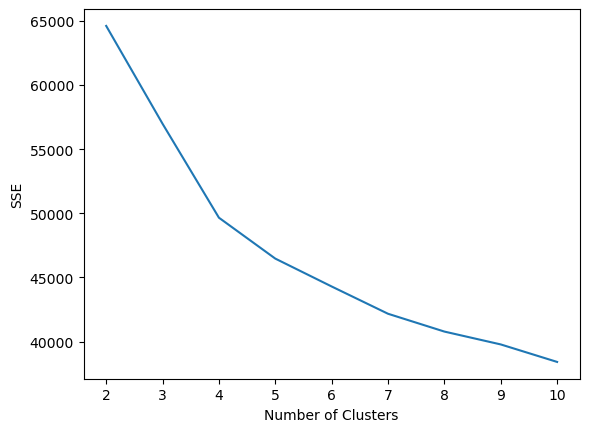

In [ ]:
# plot sse scores
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

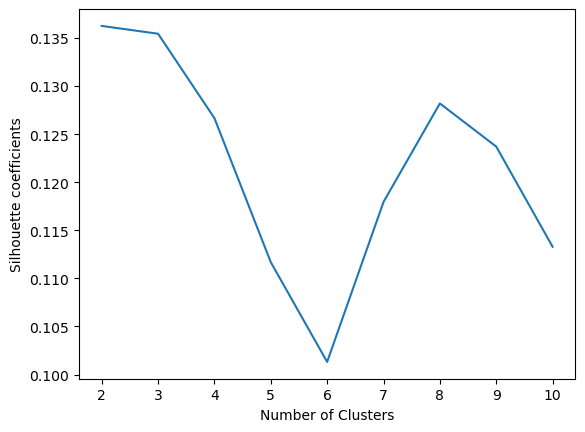

In [ ]:
# plot silhouette scores
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

From the above 2 graphs, we see that the elbow point seems to be at when k = 3, and the silhouette_score rapidly decreases after k = 3.

Therefore, the number of the clusters that will be used is k = 3.

In [ ]:
clusters = KMeans(n_clusters=3, n_init = 10)
clusters.fit(complete_df)

updated_rating['Cluster'] = clusters.labels_
updated_rating.head()

,anime_id,name,type,episodes,rating,members,genre1,genre2,genre3,genre4,Cluster
0,32281,Kimi no Na wa,Movie,1,9.37,200630,Drama,Romance,School,Supernatural,1
1,5114,Fullmetal Alchemist Brotherhood,TV,64,9.26,793665,Action,Adventure,Drama,Fantasy,1
2,28977,Gintama°,TV,51,9.25,114262,Action,Comedy,Historical,Parody,1
3,9253,SteinsGate,TV,24,9.17,673572,Sci-Fi,Thriller,None,None,1
4,9969,Gintama039,TV,51,9.16,151266,Action,Comedy,Historical,Parody,1


In [ ]:
updated_rating.Cluster.value_counts()

0    6337
1    5482
2      11
Name: Cluster, dtype: int64